# Eligibility Traces 

This Jupyter notebook file gives an overview of the general idea of eligibility traces explained in Chapter 7: Eligibility Traces of the book "Reinforcement Learning: An Introduction" written by Sutton and Barto (Second edition) and guides how the described methods can be implemented and used to solve prediction (:=estimate true value of a state under a given polciy) and control problems (:=finding an optimal policy). The tutorial is designed to follow the structure of chapter 7.

Outline:

- 7.0 Environment: Random Walk
    - 7.0.1 Create environment
    - 7.0.2 Test environment
- 7.1 N-Step TD Prediction
    - 7.1.1 On-line updating - Implementation
    - 7.1.2 On-line updating - Evaluation
    - 7.1.3 On-line updating - Plot RMS error
    - 7.1.4 Off-line updating - Implementation
    - 7.1.5 Off-line updating - Evaluation
    - 7.1.6 Off-line updating - Evaluation
    - 7.1.7 Off-line updating - Plot RMS error
- 7.2 The forward view of TD($\lambda$)
    - 7.2.1 On-line $\lambda$-return algorithm - Implementation
    - 7.2.2 On-line $\lambda$-return algorithm - Evaluation
    - 7.2.3 On-line $\lambda$-return algorithm - Plot RMS error
- 7.3 The backward view of TD($\lambda$)
    - 7.3.1 On-line TD($\lambda$) algorithm - Implementation
    - 7.3.2 On-line TD($\lambda$) algorithm - Evaluation
    - 7.3.3 On-line TD($\lambda$) algorithm - Plot RMS Error
    - 7.3.4 Off-line TD($\lambda$) algorithm - Implementation
    - 7.3.5 Off-line TD($\lambda$) algorithm - Evaluation
    - 7.3.6 Off-line TD($\lambda$) algorithm - Plot RMS Error
    - 7.3.7 True On-line TD($\lambda$) algorithm - Implementation
    - 7.3.8 True On-line TD($\lambda$) algorithm - Evaluation
    - 7.3.9 True On-line TD($\lambda$) algorithm - Plot RMS Error
- 7.4 Random walk with less states
- 7.5 Use eligibility traces to solve control problem
    - 7.5.1 Grid world environment
    - 7.5.2 Sarsa($\lambda$)
    - 7.5.3 Q($\lambda$)
- 7.6 Test eligibility traces on a more complex environment - Car Parking
    - 7.6.1 Description of the environment
    - 7.6.2 Train Sarsa($\lambda$) agent on environment
    - 7.6.3 Visualize paths taken by the car
    - 7.6.4 Render trained agent on GUI
    - 7.6.5 Evaluate agent for different values of $\lambda$ and $\alpha$

Author: Theiventhiram, Derin <br>
Supervisor: Koppe, Georgia and Pritsch, Marc <br>

Heidelberg University <br>
Faculty of Mathematics and Computer Science <br>
Seminar Reinforcement Learning <br>

# 7.0 Environment: Random Walk 

To analyze the performance of all methods shown in this code tutorial, we first need an environment under test. 

In the following, we will create a custom environment for the n-step Random Walk task which was introduced in chapter 6 of the book by Sutton and Barto (Example 6.2).

Environment description:

- Observation space: The env has n non terminal states where n is an odd number.
- Action space: The env has two actions: go left or go right.
- Episode: The agent starts at the center state ($s_0=(n+1)/2$) and decides each step if it wants to go left or right. The environment is deterministic so if the agent decides to go right then he will definitely ends at state $s_{t+1}=s_{t}+1$. If the agent reaches the right end ($s=n+1$) then it gets +1 reward and the episode terminates. If the agent reaches the left end then it gets -1 reward and the episode ends too. For all other state transitions 0 reward is received.

Example for 5-Step-Random Walk:

$S_0$  <----->  $S_1$ <-----> $S_2$ <-----> $S_3$ <-----> $S_4$ <-----> $S_5$ <-----> $S_6$

where <br>
$S_0$ := Left end<br>
$S_3$ := Center <br>
$S_6$ := Right end <br>

### 7.0.1 Create environment

In [1]:
import numpy as np
import pickle

class RandomWalk():
    """
    Random Walk Task

    Action space:
    # 0: Go left
    # 1: Go right

    observation space: 
    # n non terminal states where n is an odd number
    # 0: left terminal state => reward=-1
    # num_states+1: right terminal state => reward=+1
    # (num_states+1)/2: center
    -------------------------------------------------------------
    Attributes:

    action_space:
        Action space of environment

    observation_space:
        Observation space of environment   

    -------------------------------------------------------------

    Methods:

    reset:
        Reset game so that agent starts at center state 

    step:
        Perform an action on the environment

    render:
        Render the environment by printing the result on terminal

    """
    def __init__(self, num_states=5):
        self.action_space = [0,1]
        self.num_states = num_states

        # reset the environment
        self.reset()

    def reset(self):
        """
        Reset game so that agent starts at center state 
        """
        self.new_state = int((self.num_states + 1 )/2) 
        self.last_state = self.new_state
        self.current_round = 0
        self.action_taken = None

        return self.last_state
    
    def step(self, action):
        """   
        Perform an action on the environment

        parameters:

        action:
            0: Go left
            1: Go right
        """

        self.last_state = self.new_state
        reward = 0

        if action == 0:
            self.new_state = self.last_state - 1

        elif action == 1:
            self.new_state = self.last_state + 1
        else:
            return ValueError
        
        if self.new_state == 0: # left end reached
            reward = -1
        elif self.new_state == self.num_states + 1: # right end reached
            reward = 1

        self.action_taken = action

        self.current_round += 1

        # terminated if termination state reached or too many rounds played
        done = self.current_round >= self.num_states * 100 or self.new_state == self.num_states+1  or self.new_state == 0


        return self.new_state, reward, done
    

    def render(self):
        """
        Render the environment by printing the result on terminal

        Note: Don't provide mode as parameter

        """

        state_to_string = {
            0: "Go left",
            1: "Go right",
        }

        print(f"Step: {self.current_round:<5} | "
                f"Current State: {self.last_state} | "
                f"Distance (Number of steps) to goal: {self.num_states +1 - self.last_state } | "
                f"Action: {state_to_string[self.action_taken]} ")
        
        if self.new_state == self.num_states+1:
            print("End: Goal reached")
        elif self.new_state == 0:
            print("End: Goal NOT reached")

### 7.0.2 Test environment

Lets test the environment by running an episode with random actions on the 5-step Random Walk.

In [2]:
def play_random_episode(num_states):
    env = RandomWalk(num_states=num_states)
    
    done = False

    while not done:
        action = np.random.choice(env.action_space)
        _, _, terminated, = env.step(action)
        env.render()
        done = terminated

play_random_episode(num_states=5)

Step: 1     | Current State: 3 | Distance (Number of steps) to goal: 3 | Action: Go right 
Step: 2     | Current State: 4 | Distance (Number of steps) to goal: 2 | Action: Go right 
Step: 3     | Current State: 5 | Distance (Number of steps) to goal: 1 | Action: Go right 
End: Goal reached


## 7.1 n-Step TD-Prediction


In Chapter 5, the Monte Carlo aproach was presented which uses the entire sequence of the episode to compute the new estimated values
of the states. The return at time step $t$ is defined as follows $$G_t = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T-t-1}R_T$$ where t is the current time step and T is the number of steps until the episode ends.<br>
On the other hand, the Temporal Difference (TD(0)) method described in chapter 6 looks just one step in future to get the prediction error, which is the difference between later estimate and earlier estimate. The later estimate (:=target), is just the next reward summed up with the estimated value of the next state $$G_t = R_{t+1} + \gamma V_t(S_t+1)$$ 

So at one hand, we have a full backup while on the other end, we perform an one-step backup.

This setup can be generalized by defining the n-step TD method where the value estimates are based on n steps later. If n=1, then we obtain the simple one-step TD method and if if n is such big that the episode ends before we reach n steps, then the n-step TD method returns the complete return.

To sum up, the the n-step backup, is defined as 
$$G_t^{t+n}(S_t) = R_{t+1} + \gamma R_{t+2} + ... + \gamma^n V_t(S_{t+n})$$
and the increment is defined as 
$$\Delta_t(S_t)=\alpha [G_t^{t+n}(S_t) - V_t(S_t)]$$

There are two ways how we can update our earlier estimated value:

1. **Online updating**: The estimated value is updated **during** the episode as soon as the increment can be computed (We reached n steps later).
$$V_{t+1} = V_{t}(s) + \Delta_t(s)$$

2. **Offline updating**:
The estimated value is updated **after** the end of the episode.
$$ V_{t+1}(s) = V_t(s), \forall t < T $$ 
$$V_T(s) = V_{T-1}(s) + \sum_{t=0}^{T-1} \Delta_t(s)$$

Again, T is the termination step of the episode.

In the following, both methods are implemented however note that the n-step TD method in general is very inefficient because we have to wait n-steps until we can update our estimated values and especially for control applications, these methods could be not appropriate.

### 7.1.1 On-line updating - Implementation

In [3]:
def NStepTDOnline(env, n: int, alpha, gamma, initial_V):
    """
    n-Step TD Prediction with on-line updating rule.

    Parameters:
    env:
        environment under which method is trained
    n: 
        number of future steps which have impact on the estimated value of a state
    alpha:
        learning rate: impact of prediction error
    initial_V:
        initial estimated values
    """
    V = initial_V.copy()  # initialize state-value function
    
    state = env.reset() # get initial state

    rewards = np.array([0])
    states = [state] # save states at time step t
    t = 0  # monitor time step

    # At the current moment we don't now the end of the episode since its a random walk game.
    # T gets updated as soon as we reach the episodes end
    T = float('inf') 

    while True:
        t += 1
        
        if t < T: # perform interaction with environment until end of epsiode is reached
            action = np.random.randint(len(env.action_space)) # receive action from agent policy
            next_state, reward, done = env.step(action) # perform action
        
            rewards = np.append(rewards,reward)
            states.append(next_state)

            if done:
                T = t # update T
        
        t_minus_n = t - n # monitor update time (we have to wait n steps until an update can be performed for a state at time step t)
        if t_minus_n >= 0: # we have n future steps
            indices = np.arange(t_minus_n+1, min(t_minus_n + n, T)+1) 
            nstepBackup = np.dot(np.power(gamma, indices - t_minus_n-1), rewards[indices])

            if t_minus_n + n <T:
                nstepBackup += gamma ** n * V[states[t_minus_n + n]-1]

            incrememt = alpha * (nstepBackup - V[states[t_minus_n]-1])
            V[states[t_minus_n]-1] += incrememt
        
        if t_minus_n == T - 1: # stop when all states were updated. 
            break

        state = next_state
            
    return V

**Explaination of the implementation**:

To realize the on-line updating, we introduce the variable $\text{t\_minus\_n}$ which should monitor the time where a value estimate of a state can be updated.<br>
Suppose, we are starting at $t=0$ ($s_0$= Center state) and we want to perform a 5-step backup. Then, $V(s_0)$ can be updated as soon as we reached $t=5$. We can check it by $\text{t\_minus\_n}= t - n$ which is zero for this case. Since we have to update each state (we save all visited states in an array) as soon as the increment can be computed, $\text{t\_minus\_n}$ is used to access the state which is ready to update.

As the episode can end before we reach n steps, we use $\min(\text{t\_minus\_n}$, T)$ to define the number of steps which can be used for update.
Note, that the end of the episode is not known at the current moment since we perform a random walk. So we first set $T$ to infinity and update it as soon as the episode ends. 

When the episode ends, we still increase the time step to update all states for which the n-step backup is simply the Monte Carlo method and we stop until $\text{t\_minus\_n} = T - 1$.


### 7.1.2 On-line updating - Evaluation

Lets test the n-step TD method with on-line updating rule.

The setting of the random walk game described in chapter 7 is the following (We will use this setting for all methods in this tutorial):

- The game has 19 states 
- all values are initialized to zero
- We run the game over the 10 episodes and repeat it 100 times (the errors are averaged over 10*100)
- We test the method with a range of values for $n$ and $\alpha$

Setting:

In [4]:
NUM_STATES_19 = 19
V_INITIAL_19 = np.zeros(NUM_STATES_19) 
V_TRUE_19 = np.arange(-18, 20, 2) / 20.0
ENV_19 =  RandomWalk(num_states=NUM_STATES_19)
GAMMA = 1
NUM_EPISODES = 10
RUNS = 100

ALPHAS = np.arange(0,1.1,0.1)
NSTEPS = np.power(2, np.arange(0, 10))

In [5]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

"""
Compute RMS prediction error of online n-step-TD method over a specified number of episodes averaged by a specified number of runs on the Random Walk environment.
Method is tested against different values of alpha and n. gamma is fixed.
"""
def nStepTDMethodOnlineRandomWalkPlot(num_states, v_initial, v_true, env, gamma, runs, alphas, nsteps, file_path):
    rms_errors_nstepTD_online = None

    if os.path.exists(file_path): # load rms error 
        with open(file_path, 'rb') as file:
            rms_errors_nstepTD_online = pickle.load(file)
    else:
        rms_errors_nstepTD_online = np.zeros((len(nsteps), len(alphas)))

        for run in tqdm(range(0, runs)): # loop over runs
            for step_ind, step in enumerate(nsteps): # loop over n
                for alpha_ind, alpha in enumerate(alphas): # loop over alpha
                    V = v_initial.copy() # reset value estimates after specified number of episodes
                    for episode in range(0, NUM_EPISODES): # loop over episodes
                        V = NStepTDOnline(env=env, 
                            n=step,
                            gamma=gamma,
                            alpha=alpha,
                            initial_V = V) # update value estimated 
                        
                        # calculate the RMS error
                        rms_errors_nstepTD_online[step_ind, alpha_ind] += np.sqrt(np.sum(np.power(V - v_true, 2)) / num_states) # compute rms error and save to array

        # take average
        rms_errors_nstepTD_online /= NUM_EPISODES * runs

        with open(file_path, 'wb') as file: # save rms error to load it next time
            pickle.dump(rms_errors_nstepTD_online, file)
    
    return rms_errors_nstepTD_online

rms_errors_nstepTD_online = nStepTDMethodOnlineRandomWalkPlot(NUM_STATES_19, V_INITIAL_19, V_TRUE_19, ENV_19, GAMMA, RUNS, ALPHAS, NSTEPS, 'rms_errors_nstepTD_online_RandomWalk_19.array' )

### 7.1.3 On-line updating - Plot RMS error

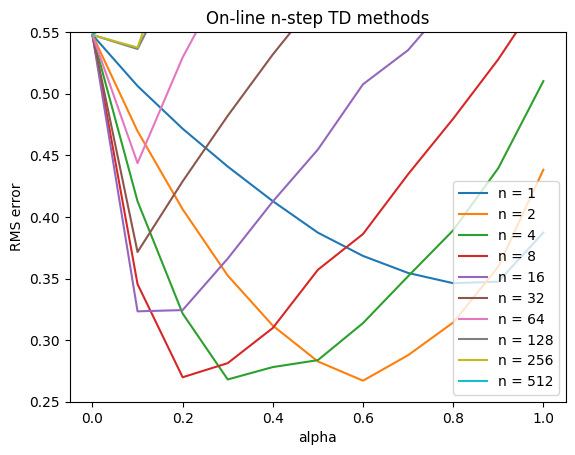

In [6]:
for i in range(0, len(NSTEPS)):
    plt.plot(ALPHAS, rms_errors_nstepTD_online[i, :], label=f"n = {NSTEPS[i]}")

plt.title(f"On-line n-step TD methods")
plt.xlabel('alpha')
plt.ylabel('RMS error')
plt.ylim([0.25,0.55])

plt.legend()
plt.show()

Observation: 
- for n = 2, n = 4 and n=8, the performance is best among all tested values for n
- in general, intermediate n-step TD methods are better than the tow extremes, TD(0) and MC

### 7.1.4 Off-line updating - Implementation

In [7]:
def NStepTDOffline(env, n: int, alpha, gamma, initial_V):
    """
    n-Step TD Prediction with off-line update rule.

    Parameters:
    env:
        environment under which method is trained
    n: 
        number of future steps which have impact on the estimated value of current step
    alpha:
        learning rate: impact of prediction error
    initial_V:
        initial estimated values
    """
    V = initial_V.copy()  # Initialize state-value function
    
    state = env.reset() # get initial state

    rewards = np.array([0])
    states = [state] # save states at time step t
    t = 0  # monitor time step

    # At the current moment we don't now the end of the episode since its a random walk game.
    # T gets updated as soon as we reach the episodes end
    T = float('inf') 

    while True:
        t += 1
        
        action = np.random.randint(len(env.action_space)) # receive action from agent policy
        next_state, reward, done = env.step(action) # perform action
    
        rewards = np.append(rewards,reward)
        states.append(next_state)

        if done:
            T = t # update T
            break

        state = next_state

    increments = np.zeros(env.num_states)

    # off-line updating rule, increments are accumulated on the side
    for i in range(T):
        indices = np.arange(i + 1, min(i + n, T) + 1) 
        nstepBackup = np.dot(np.power(gamma, indices - i - 1), rewards[indices])

        if i + n <T:
            nstepBackup += gamma ** n * V[states[i + n]-1]

        increment = alpha * (nstepBackup - V[states[i]-1])
        increments[states[i]-1] += increment

    V += increments # update value estimate based on the sum of all increments
            
    return V

**Explaination of the implementation**:

The implementation of the off-line n-step TD methods is similar to the on-line one except that we don't need the variable $\text{t\_minus\_n}$ since the increments are accumulated on the side so we can wait until the episode terminates and then perform the update of the value estimates.

### 7.1.6 Off-line updating - Evaluation

In [8]:
from tqdm import tqdm

"""
Compute RMS prediction error of offline n-step-TD method over a specified number of episodes averaged by a specified number of runs on the Random Walk environment.
Method is tested against different values of alpha and n. gamma is fixed.
"""
def nStepTDMethodOfflineRandomWalkPlot(num_states, v_initial, v_true, env, gamma, runs, alphas, nsteps, file_path):
    rms_errors_nstepTD_offline = None

    if os.path.exists(file_path):
        with open(file_path, 'rb') as file:
            rms_errors_nstepTD_offline = pickle.load(file)

    else:    
        rms_errors_nstepTD_offline= np.zeros((len(nsteps), len(alphas)))

        for run in tqdm(range(0, runs)):
            for step_ind, step in enumerate(nsteps):
                for alpha_ind, alpha in enumerate(alphas):
                    V = v_initial.copy()
                    for episode in range(0, NUM_EPISODES):
                        V = NStepTDOffline(env=env, 
                            n=step,
                            gamma=gamma,
                            alpha=alpha,
                            initial_V = V)
                        
                        # calculate the RMS error
                        rms_errors_nstepTD_offline[step_ind, alpha_ind] += np.sqrt(np.sum(np.power(V - v_true, 2)) / num_states)

        # take average
        rms_errors_nstepTD_offline /= NUM_EPISODES * runs

        with open(file_path, 'wb') as file:
            pickle.dump(rms_errors_nstepTD_offline, file)

    return rms_errors_nstepTD_offline

rms_errors_nstepTD_offline = nStepTDMethodOfflineRandomWalkPlot(NUM_STATES_19, V_INITIAL_19, V_TRUE_19, ENV_19, GAMMA, RUNS, ALPHAS, NSTEPS, 'rms_errors_nstepTD_offline_RandomWalk_19.array')

### 7.1.7 Off-line updating - Plot RMS error

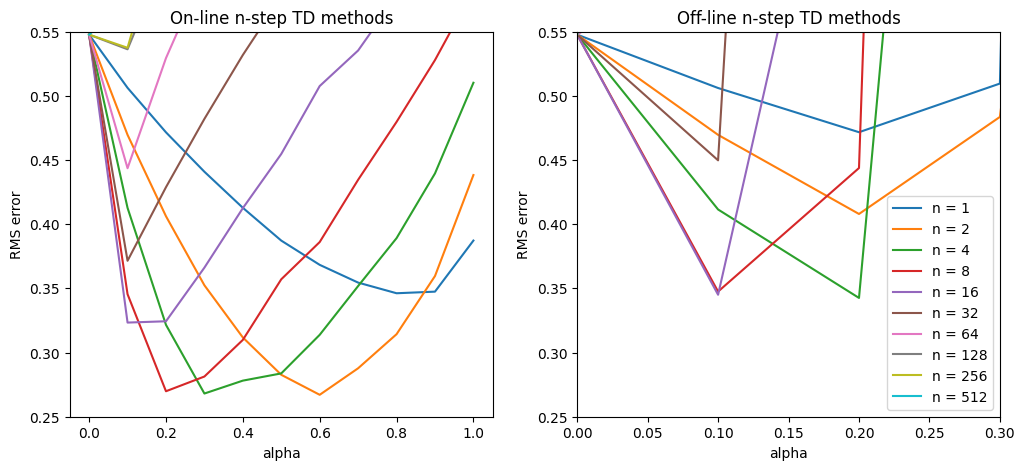

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize = (12,5))
for i in range(0, len(NSTEPS)):
    ax[0].plot(ALPHAS, rms_errors_nstepTD_online[i, :], label=f"n = {NSTEPS[i]}")
    ax[1].plot(ALPHAS, rms_errors_nstepTD_offline[i, :], label=f"n = {NSTEPS[i]}")

    ax[0].set_xlabel('alpha')
    ax[1].set_xlabel('alpha')

    ax[0].set_ylabel('RMS error')
    ax[1].set_ylabel('RMS error')

    ax[0].set_ylim([0.25,0.55])
    ax[1].set_ylim([0.25,0.55])

    ax[1].set_xlim([0,0.3])

ax[0].set_title("On-line n-step TD methods")
ax[1].set_title("Off-line n-step TD methods")
plt.legend()
plt.show()

Observation:
- in comparison to the on-line n-step TD methods, the off-line one performs worse for all values of n.
- the off-line method is not stable against $\alpha >0.3$

## 7.2 The Forward view of TD($\lambda$)

The forward view gives an theoretical insight of eligbility traces. The principle is similar to the n-step TD method except that a complex backup is performed that is averaging all n-step returns by giving them weights which sum up to 1. Moreover, given $\lambda \in [0,1]$, the $\lambda$-return is defined as follows: $$L_t=(1-\lambda) \sum_{n=1}^{\infty} \lambda^{n-1}G_t^{t+n}(V_t(S_{t+n})) $$
By excluding the post-termination term, the $\lambda$-return can be defined as  $$L_t=(1-\lambda) \sum_{n=1}^{T-t-1} \lambda^{n-1}G_t^{t+n}(V_t(S_{t+n})) + \lambda^{T-t-1}G_t$$

The increment then looks as follows: $$\Delta_t(S_t) = \alpha[L_t - V_t(S_t)]$$

As the name says, the forward view update the value estimates based on future observed and estimated rewards.

### 7.2.1 On-line $\lambda$-return algorithm - Implementation

In [10]:
def LambdaReturnOnline(env, l, alpha, gamma, initial_V):
    """
    Lambda Return Prediction with on-line update rule.

    Parameters:
    env:
        Environment under which method is trained
    l: 
        decay rate
    alpha:
        learning rate: impact of prediction error
    initial_V:
        initial estimated values
    """
    V = initial_V.copy()  # Initialize state-value function
    
    state = env.reset() # get initial state

    rewards = np.array([0])
    states = [state] # save states at time step t
    t = 0  # monitor time step

    # At the current moment we don't now the end of the episode since its a random walk game.
    # T gets updated as soon as we reach the episodes end
    T = float('inf') 

    while True:
        t += 1
        
        action = np.random.randint(len(env.action_space)) # receive action from agent policy
        next_state, reward, done = env.step(action) # perform action
    
        rewards = np.append(rewards,reward)
        states.append(next_state)

        if done:
            T = t # update T
            break

        state = next_state

    for i in range(T):
        L_t = 0

        for n in range(1, T-i-1): # Compute n-step return
            indices = np.arange(i+1, i+n+1)
            nstepBackup = np.dot(np.power(gamma, indices - i-1), rewards[indices])

            nstepBackup += gamma ** n * V[states[i + n]-1]

            L_t += np.power(l, n-1) * nstepBackup 
        
        L_t = L_t * (1-l)
        
        # post-termination term
        indices = np.arange(i+1, T+1)
        nstepBackup = np.dot(np.power(gamma, indices - i-1), rewards[indices])

        L_t += np.power(l, T-i-1) * nstepBackup # lambda return 
        
        increment = alpha * (L_t - V[states[i]-1])
        V[states[i]-1] += increment # update value estimate
        
    return V
    

Note:
This naive implementation is very inefficient and takes long when being executed. 

### 7.2.2 On-line $\lambda$-return algorithm - Evaluation

Setting 

In [11]:
LAMBDAS = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1.0] # algorithm will be tested against different values for lambda

In [12]:
from tqdm import tqdm


"""
Compute RMS prediction error of lambda-return method over a specified number of episodes averaged by a specified number of runs on the Random Walk environment.
Method is tested against different values of alpha and lambda. gamma is fixed.
"""
def lambdaReturnOnlineRandomWalkPlot(num_states, v_initial, v_true, env, gamma, runs, alphas, lambdas, file_path):
    rms_errors_lamdaReturn_online= None

    if os.path.exists(file_path):
        with open(file_path, 'rb') as file:
            rms_errors_lamdaReturn_online = pickle.load(file)

    else:    
        rms_errors_lamdaReturn_online= np.zeros((len(lambdas), len(alphas)))

        for run in tqdm(range(0, runs)):
            for lambda_ind, l in enumerate(lambdas):
                for alpha_ind, alpha in enumerate(alphas):
                    V = v_initial.copy()
                    for episode in range(0, NUM_EPISODES):
                        V = LambdaReturnOnline(env=env, 
                            l=l,
                            gamma=gamma,
                            alpha=alpha,
                            initial_V = V)
                        
                        # calculate the RMS error
                        rms_errors_lamdaReturn_online[lambda_ind, alpha_ind] += np.sqrt(np.sum(np.power(V - v_true, 2)) / num_states)

        # take average
        rms_errors_lamdaReturn_online /= NUM_EPISODES * runs

        with open(file_path, 'wb') as file:
            pickle.dump(rms_errors_lamdaReturn_online, file)

    return rms_errors_lamdaReturn_online

rms_errors_lamdaReturn_online = lambdaReturnOnlineRandomWalkPlot(NUM_STATES_19, V_INITIAL_19, V_TRUE_19, ENV_19, GAMMA, RUNS, ALPHAS, LAMBDAS, 'rms_errors_lambda_return_online_RandomWalk_19.array')

### 7.2.3 On-line $\lambda$-return algorithm - Plot RMS error

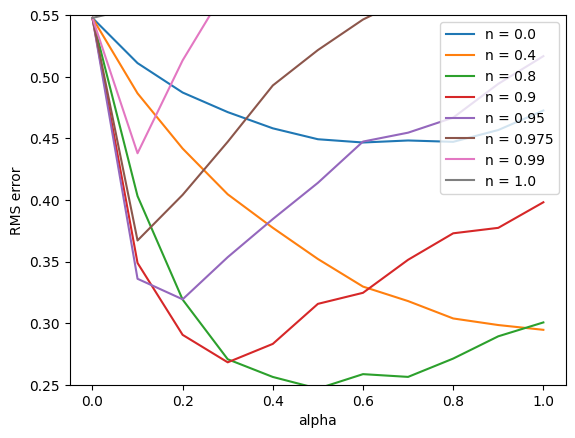

In [13]:
for i in range(0, len(LAMBDAS)):
    plt.plot(ALPHAS, rms_errors_lamdaReturn_online[i, :], label=f"n = {LAMBDAS[i]}")

plt.xlabel('alpha')
plt.ylabel('RMS error')
plt.ylim([0.25,0.55])

plt.legend()
plt.show()

Observation:
- Similar to the on-line n-step TD method, an intermediate value for $\lambda$ yields better performance on the 19-step Random Walk than the two extremes TD(0) and MC
- The optimal RMS prediction error is achieved for $n=0.8$ and $\alpha \approx 0.5$ and reads about 0.25 which is slightly better than the optimum in the on-line n-step TD method (about 0.27)

## 7.3 The Backward view of TD($\lambda$)

The backward view approximates the forward view by using eligibility traces $E_t(s) \in \mathbb{R}^+$ that can be considered as "memory variables" which record the trace of a state.

The eligibility trace is be updated as follows:
$$E_t(S_t) = (1 − \alpha)\gamma \lambda E_{t−1}(S_t) + 1 .$$

This is called "dutch" trace. Special cases: 
- If $\alpha=0$ then the trace is called "accumulating" trace
- If $\alpha=1$ then the trace is called "replacing" trace.

For all other states $s\neq S_t$:
$$ E_t(s) = \gamma \lambda E_{t-1}(s)$$


In the backward view, the update of the value estimate is not based on future observed and estimated rewards anymore. Instead, the TD($\lambda$) methods looks backwards how often a state was visited or not.

The increment is defined as:
$$\Delta V_t(s) = \alpha\delta_t E_t(s) \ \ \forall s \in S $$

### 7.3.1 On-line TD($\lambda$) algorithm - Implementation

In [14]:
def TDLambdaOnline(env, l, alpha, gamma, initial_V, mode = "dutch"):
    """
    TD(Lambda) method with on-line update rule.

    Parameters:
    env:
        Environment under which method is trained
    l: 
        decay rate
    alpha:
        learning rate: impact of prediction error
    initial_V:
        initial estimated values
    mode:
        name of trace to be used
    """
    V = initial_V.copy()  # Initialize state-value function
    E = np.zeros_like(V)

    state = env.reset()
    
    
    while True:
        action = np.random.randint(len(env.action_space)) # receive action from agent policy
        next_state, reward, done = env.step(action) # perform action
    
        if done:
            delta = reward - V[state-1]
        else:
            delta = reward + gamma * V[next_state-1] - V[state-1]

        # upaze eligibility trace according to mode
        if mode == "dutch":
            E[state-1] = (1-alpha) * E[state-1] +1
        elif mode == "accumulate":
            E[state-1] = E[state-1] + 1
        elif mode == "replacing_traces":
            E[state-1] = 1
        else:
            print("Wrong mode. Dutch trace will be used")
            E[state-1] = (1-alpha) * E[state-1] +1

        for i in range(len(E)): # update value estimates and traces of all states 
            V[i] = V[i] + alpha * delta * E[i]
            E[i] = gamma * l  * E[i]

        state = next_state

        if done: 
            break

    return V

### 7.3.2 On-line TD($\lambda$) algorithm - Evaluation

In [15]:
from tqdm import tqdm

"""
Compute RMS prediction error of online TD(lambda) method (trace is given by mode) over a specified number of episodes averaged by a specified number of runs on the Random Walk environment.
Method is tested against different values of alpha and lambda. gamma is fixed. 
"""
def tdLambdaOnlineRandomWalkPlot(num_states, v_initial, v_true, env, gamma, runs, alphas, lambdas, mode, file_path):
    rms_errors_TDLambda_Online = None

    if os.path.exists(file_path):
        with open(file_path, 'rb') as file:
            rms_errors_TDLambda_Online = pickle.load(file)

    else:    
        rms_errors_TDLambda_Online = np.zeros((len(lambdas), len(ALPHAS)))

        for run in tqdm(range(0, runs)):
            for lambda_ind, l in enumerate(lambdas):
                for alpha_ind, alpha in enumerate(alphas):
                    V = v_initial.copy()
                    for episode in range(0, NUM_EPISODES):
                        V = TDLambdaOnline(env=env, 
                            l=l,
                            gamma=gamma,
                            alpha=alpha,
                            initial_V = V,
                            mode=mode)
                        
                        # calculate the RMS error
                        rms_errors_TDLambda_Online[lambda_ind, alpha_ind] += np.sqrt(np.sum(np.power(V - v_true, 2)) / num_states)

        # take average
        rms_errors_TDLambda_Online /= NUM_EPISODES * runs

    with open(file_path, 'wb') as file:
        pickle.dump(rms_errors_TDLambda_Online, file)

    return rms_errors_TDLambda_Online

rms_errors_TDLambda_Online_Dutch = tdLambdaOnlineRandomWalkPlot(NUM_STATES_19, V_INITIAL_19, V_TRUE_19, ENV_19, GAMMA, RUNS, ALPHAS, LAMBDAS, "dutch", 'rms_errors_TDLambda_Online_Dutch_RandomWalk_19.array')
rms_errors_TDLambda_Online_Accumulating = tdLambdaOnlineRandomWalkPlot(NUM_STATES_19, V_INITIAL_19, V_TRUE_19, ENV_19, GAMMA, RUNS, ALPHAS, LAMBDAS, "accumulate", 'rms_errors_TDLambda_Online_Accumulating_RandomWalk_19.array')
rms_errors_TDLambda_Online_Replacing = tdLambdaOnlineRandomWalkPlot(NUM_STATES_19, V_INITIAL_19, V_TRUE_19, ENV_19, GAMMA, RUNS, ALPHAS, LAMBDAS, "replacing_traces", 'rms_errors_TDLambda_Online_Replacing_RandomWalk_19.array')

### 7.3.3 On-line TD($\lambda$) algorithm - Plot RMS Error

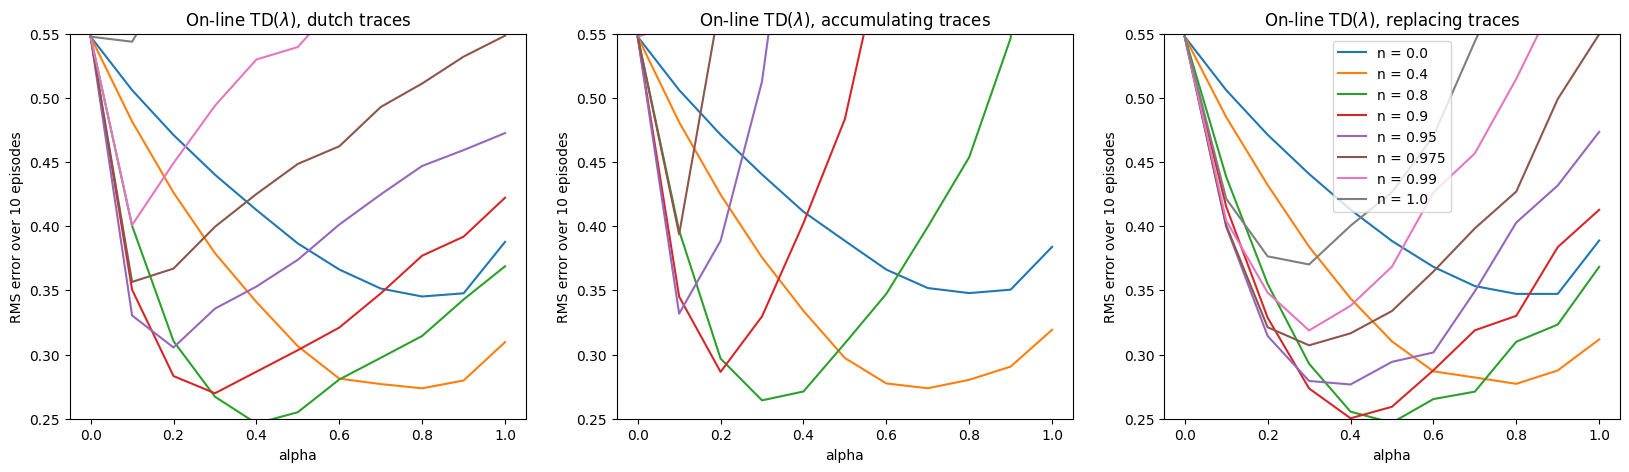

In [16]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
                       
for i in range(0, len(LAMBDAS)):
    ax[0].plot(ALPHAS, rms_errors_TDLambda_Online_Dutch[i, :], label=f"n = {LAMBDAS[i]}")
    ax[1].plot(ALPHAS, rms_errors_TDLambda_Online_Accumulating[i, :], label=f"n = {LAMBDAS[i]}")
    ax[2].plot(ALPHAS, rms_errors_TDLambda_Online_Replacing[i, :], label=f"n = {LAMBDAS[i]}")

    ax[0].set_ylim([0.25,0.55])
    ax[1].set_ylim([0.25,0.55])
    ax[2].set_ylim([0.25,0.55])

for i in range(3):
    ax[i].set_xlabel(f"alpha")
    ax[i].set_ylabel(f"RMS error over 10 episodes")


ax[0].set_title("On-line TD($\lambda$), dutch traces")
ax[1].set_title("On-line TD($\lambda$), accumulating traces")
ax[2].set_title("On-line TD($\lambda$), replacing traces")

plt.legend()
plt.show()

Observation:
- The performance of the on-line TD($\lambda$)-algorithms with "dutch", "accumulating" and "replacing" traces are very similar to the performance of the on-line $\lambda$-return algorithm

### 7.3.4 Off-line TD($\lambda$) algorithm - Implementation

Similar to off-line n-step TD methods, the increments are accumulated on the side so that the value estimates are updated at the end of the episode

In [17]:
def TDLambdaOffline(env, l, alpha, gamma, initial_V, mode = "dutch"):
    """
    TD(lambda) with offline update.

    Parameters:
    env:
        Environment under which method is trained
    l: 
        number of future steps which have impact on the estimated value of current step
    alpha:
        learning rate: impact of prediction error
    initial_V:
        initial estimated values
    mode:
        name of trace to be used
    """
    V = initial_V.copy()  # Initialize state-value function
    E = np.zeros_like(V)

    state = env.reset()

    increments = np.zeros(env.num_states)

    while True:
        action = np.random.randint(len(env.action_space)) # receive action from agent policy
        next_state, reward, done = env.step(action) # perform action
    
        if done:
            delta = reward - V[state-1]
        else:
            delta = reward + gamma * V[next_state-1] - V[state-1]

        # update eligibility trace according to mode
        if mode == "dutch":
            E[state-1] = (1-alpha) * E[state-1] +1
        elif mode == "accumulate":
            E[state-1] = E[state-1] + 1
        elif mode == "replacing_traces":
            E[state-1] = 1
        else:
            print("Wrong mode. Dutch trace will be used")
            E[state-1] = (1-alpha) * E[state-1] +1

        for i in range(len(E)):
            increments[i] += alpha * delta * E[i] # increments are accumulated on the side
            E[i] = gamma * l  * E[i]

        state = next_state

        if done: 
            break
    
    V += increments # update value estimate based on sum of all increments

    return V

### 7.3.5 Off-line TD($\lambda$) algorithm - Evaluation

In [18]:
from tqdm import tqdm

"""
Compute RMS prediction error of offline TD(lambda) method (trace is given by mode) over a specified number of episodes averaged by a specified number of runs on the Random Walk environment.
Method is tested against different values of alpha and lambda. gamma is fixed. 
"""
def tdLambdaOfflineRandomWalkPlot(num_states, v_initial, v_true, env, gamma, runs, alphas, lambdas, mode, file_path):
    rms_errors_TDLambda_Offline = None

    if os.path.exists(file_path):
        with open(file_path, 'rb') as file:
            rms_errors_TDLambda_Offline = pickle.load(file)

    else:    
        rms_errors_TDLambda_Offline = np.zeros((len(lambdas), len(ALPHAS)))

        for run in tqdm(range(0, runs)):
            for lambda_ind, l in enumerate(lambdas):
                for alpha_ind, alpha in enumerate(alphas):
                    V = v_initial.copy()
                    for episode in range(0, NUM_EPISODES):
                        V = TDLambdaOffline(env=env, 
                            l=l,
                            gamma=gamma,
                            alpha=alpha,
                            initial_V = V,
                            mode=mode)
                        
                        # calculate the RMS error
                        rms_errors_TDLambda_Offline[lambda_ind, alpha_ind] += np.sqrt(np.sum(np.power(V - v_true, 2)) / num_states)

        # take average
        rms_errors_TDLambda_Offline /= NUM_EPISODES * runs

    with open(file_path, 'wb') as file:
        pickle.dump(rms_errors_TDLambda_Offline, file)

    return rms_errors_TDLambda_Offline

rms_errors_TDLambda_Offline_Dutch = tdLambdaOfflineRandomWalkPlot(NUM_STATES_19, V_INITIAL_19, V_TRUE_19, ENV_19, GAMMA, RUNS, ALPHAS, LAMBDAS, "dutch", 'rms_errors_TDLambda_Offline_Dutch_RandomWalk_19.array')
rms_errors_TDLambda_Offline_Accumulating = tdLambdaOfflineRandomWalkPlot(NUM_STATES_19, V_INITIAL_19, V_TRUE_19, ENV_19, GAMMA, RUNS, ALPHAS, LAMBDAS, "accumulate", 'rms_errors_TDLambda_Offine_Accumulating_RandomWalk_19.array')
rms_errors_TDLambda_Offline_Replacing = tdLambdaOfflineRandomWalkPlot(NUM_STATES_19, V_INITIAL_19, V_TRUE_19, ENV_19, GAMMA, RUNS, ALPHAS, LAMBDAS, "replacing_traces", 'rms_errors_TDLambda_Offline_Replacing_RandomWalk_19.array')

### 7.3.6 Off-line TD($\lambda$) algorithm - Plot RMS error

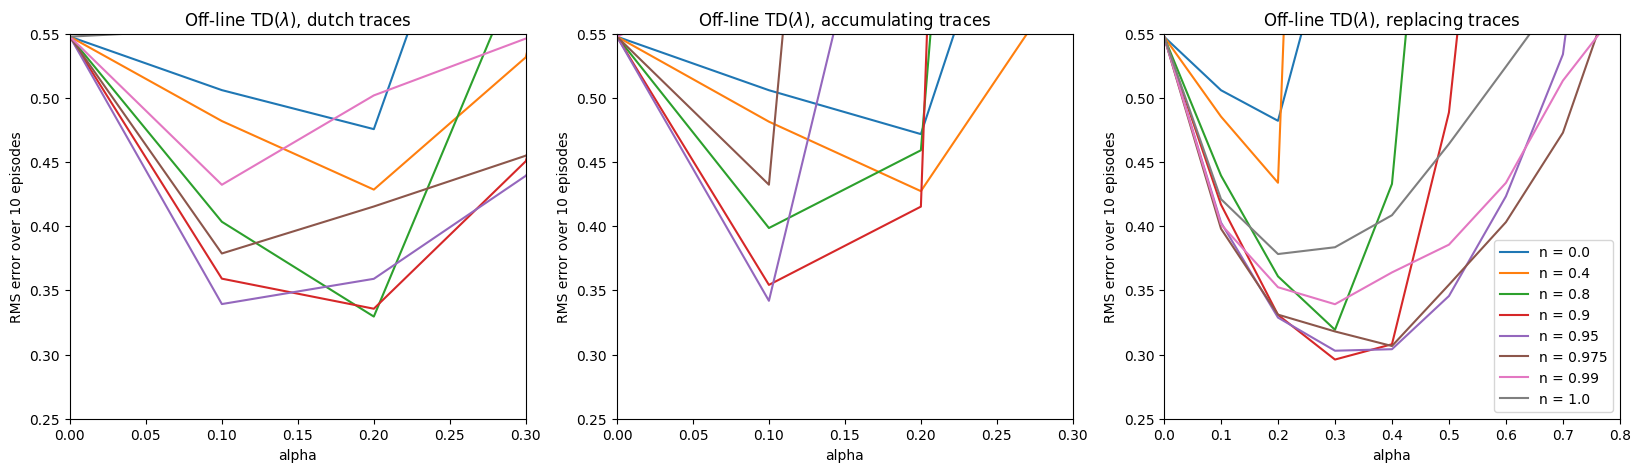

In [19]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
                       
for i in range(0, len(LAMBDAS)):
    ax[0].plot(ALPHAS, rms_errors_TDLambda_Offline_Dutch[i, :], label=f"n = {LAMBDAS[i]}")
    ax[1].plot(ALPHAS, rms_errors_TDLambda_Offline_Accumulating[i, :], label=f"n = {LAMBDAS[i]}")
    ax[2].plot(ALPHAS, rms_errors_TDLambda_Offline_Replacing[i, :], label=f"n = {LAMBDAS[i]}")

    ax[0].set_ylim([0.25,0.55])
    ax[1].set_ylim([0.25,0.55])
    ax[2].set_ylim([0.25,0.55])

    ax[0].set_xlim([0,0.3])
    ax[1].set_xlim([0,0.3])
    ax[2].set_xlim([0,0.8])

for i in range(3):
    ax[i].set_xlabel(f"alpha")
    ax[i].set_ylabel(f"RMS error over 10 episodes")


ax[0].set_title("Off-line TD($\lambda$), dutch traces")
ax[1].set_title("Off-line TD($\lambda$), accumulating traces")
ax[2].set_title("Off-line TD($\lambda$), replacing traces")

plt.legend()
plt.show()

Observation:
- The performance of the off-line TD($\lambda$)-algorithms with "dutch", "accumulating" traces are very similar to the performance of the off-line n-step TD method
- Interestingly, the off-line TD($\lambda$)-algorithm with "replacing" traces is more stable than the ones using the other two traces. The methods keeps stable for $\alpha \leq 0.8$.

### 7.3.7 True On-line TD($\lambda$) algorithm - Implementation

In [20]:
def trueTDLambdaOnline(env, l, alpha, gamma, initial_V):
    """
    true TD(lambda) with online update.

    Parameters:
    env:
        Environment under which method is trained
    l: 
        decay rate
    alpha:
        learning rate: impact of prediction error
    initial_V:
        initial estimated values
    """
    V = initial_V.copy()  # Initialize state-value function
    V_old = 0
    E = np.zeros_like(V)

    state = env.reset()

    while True:
        action = np.random.randint(len(env.action_space)) # receive action from agent policy
        next_state, reward, done = env.step(action) # perform action
    
        delta_big = V[state-1] - V_old
        if done:
            delta = reward - V[state-1]
        else:
            delta = reward + gamma * V[next_state-1] - V[state-1]
            V_old = V[next_state-1]

        E[state-1] = (1-alpha) * E[state-1] +1

        for i in range(len(E)):
            V[i] += alpha * (delta+delta_big) * E[i]
            E[i] = gamma * l  * E[i]

        V[state-1] = V[state-1] - alpha * delta_big

        state = next_state

        if done: 
            break

    return V

### 7.3.8 True On-line TD($\lambda$) algorithm - Evaluation

In [21]:
from tqdm import tqdm

"""
Compute RMS prediction error of true online TD(lambda) method (trace is given by mode) over a specified number of episodes averaged by a specified number of runs on the Random Walk environment.
Method is tested against different values of alpha and lambda. gamma is fixed. 
"""
def tdLambdaTrueOnlineRandomWalkPlot(num_states, v_initial, v_true, env, gamma, runs, alphas, lambdas, file_path):
    rms_errors_TDLambda_True_Online = None

    if os.path.exists(file_path):
        with open(file_path, 'rb') as file:
            rms_errors_TDLambda_True_Online = pickle.load(file)

    else:    
        rms_errors_TDLambda_True_Online = np.zeros((len(lambdas), len(ALPHAS)))

        for run in tqdm(range(0, runs)):
            for lambda_ind, l in enumerate(lambdas):
                for alpha_ind, alpha in enumerate(alphas):
                    V = v_initial.copy()
                    for episode in range(0, NUM_EPISODES):
                        V = trueTDLambdaOnline(env=env, 
                            l=l,
                            gamma=gamma,
                            alpha=alpha,
                            initial_V = V)
                        
                        # calculate the RMS error
                        rms_errors_TDLambda_True_Online[lambda_ind, alpha_ind] += np.sqrt(np.sum(np.power(V - v_true, 2)) / num_states)

        # take average
        rms_errors_TDLambda_True_Online /= NUM_EPISODES * runs

    with open(file_path, 'wb') as file:
        pickle.dump(rms_errors_TDLambda_True_Online, file)

    return rms_errors_TDLambda_True_Online

rms_errors_TDLambda_True_Online = tdLambdaTrueOnlineRandomWalkPlot(NUM_STATES_19, V_INITIAL_19, V_TRUE_19, ENV_19, GAMMA, RUNS, ALPHAS, LAMBDAS, 'rms_errors_TDLambda_True_Online_RandomWalk_19.array')

### 7.3.9 True On-line TD($\lambda$) algorithm - Plot RMS error

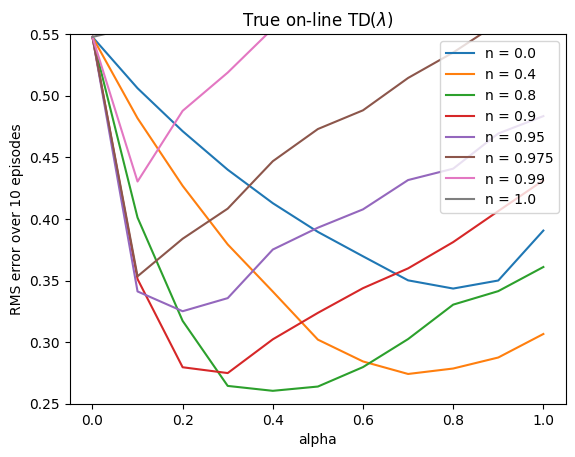

In [22]:
for i in range(0, len(LAMBDAS)):
    plt.plot(ALPHAS, rms_errors_TDLambda_True_Online[i, :], label=f"n = {LAMBDAS[i]}")

plt.ylim([0.25,0.55])
plt.xlabel(f"alpha")
plt.ylabel(f"RMS error over 10 episodes")

plt.title("True on-line TD($\lambda$)")

plt.legend()
plt.show()

Observation:
- Again, the performance of the true on-line TD($\lambda$) method is similar to the other methods with on-line updating rule

## 7.4 Random walk with less states

To further check the performance of all methods which we have been gone through so far, we test them agains the 9-step Random Walk

Setting

In [23]:
NUM_STATES_9 = 9
V_INITIAL_9 = np.zeros(NUM_STATES_9) 
V_TRUE_9 = np.arange(-8, 10, 2) / 10

ENV_9 =  RandomWalk(num_states=NUM_STATES_9)
GAMMA = 1
NUM_EPISODES = 10
RUNS = 100

ALPHAS = np.arange(0,1.1,0.1)
NSTEPS = np.power(2, np.arange(0, 10))

In [24]:
rms_errors_nstepTD_online_9 = nStepTDMethodOnlineRandomWalkPlot(NUM_STATES_9, V_INITIAL_9, V_TRUE_9, ENV_9, GAMMA, RUNS, ALPHAS, NSTEPS, 'rms_errors_nstepTD_online_RandomWalk_9.array' )
rms_errors_nstepTD_offline_9 = nStepTDMethodOfflineRandomWalkPlot(NUM_STATES_9, V_INITIAL_9, V_TRUE_9, ENV_9, GAMMA, RUNS, ALPHAS, NSTEPS, 'rms_errors_nstepTD_offline_RandomWalk_9.array')

rms_errors_TDLambda_Online_Dutch_9 = tdLambdaOnlineRandomWalkPlot(NUM_STATES_9, V_INITIAL_9, V_TRUE_9, ENV_9, GAMMA, RUNS, ALPHAS, LAMBDAS, "dutch", 'rms_errors_TDLambda_Online_Dutch_RandomWalk_9.array')
rms_errors_TDLambda_Online_Accumulating_9 = tdLambdaOnlineRandomWalkPlot(NUM_STATES_9, V_INITIAL_9, V_TRUE_9, ENV_9, GAMMA, RUNS, ALPHAS, LAMBDAS, "accumulate", 'rms_errors_TDLambda_Online_Accumulating_RandomWalk_9.array')
rms_errors_TDLambda_Online_Replacing_9 = tdLambdaOnlineRandomWalkPlot(NUM_STATES_9, V_INITIAL_9, V_TRUE_9, ENV_9, GAMMA, RUNS, ALPHAS, LAMBDAS, "replacing_traces", 'rms_errors_TDLambda_Online_Replacing_RandomWalk_9.array')
rms_errors_lamdaReturn_online_9 = lambdaReturnOnlineRandomWalkPlot(NUM_STATES_9, V_INITIAL_9, V_TRUE_9, ENV_9, GAMMA, RUNS, ALPHAS, LAMBDAS, 'rms_errors_lambda_return_online_RandomWalk_9.array')
rms_errors_TDLambda_True_Online_9 = tdLambdaTrueOnlineRandomWalkPlot(NUM_STATES_9, V_INITIAL_9, V_TRUE_9, ENV_9, GAMMA, RUNS, ALPHAS, LAMBDAS, 'rms_errors_TDLambda_True_Online_RandomWalk_9.array')
rms_errors_TDLambda_Offline_Accumulating_9 = tdLambdaOfflineRandomWalkPlot(NUM_STATES_9, V_INITIAL_9, V_TRUE_9, ENV_9, GAMMA, RUNS, ALPHAS, LAMBDAS, "accumulate", 'rms_errors_TDLambda_Offine_Accumulating_RandomWalk_9.array')

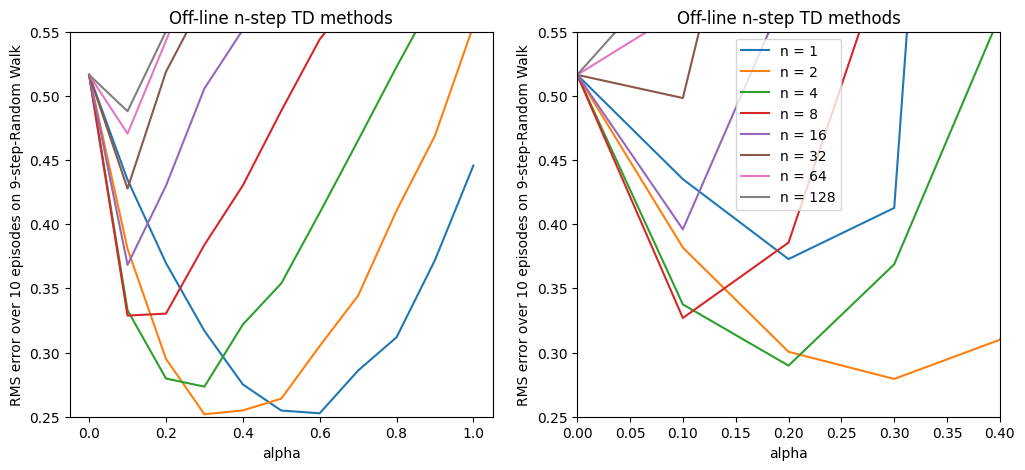

In [25]:
fig, ax = plt.subplots(1,2, figsize= (12,5))

for i in range(0, len(LAMBDAS)):
    ax[0].plot(ALPHAS, rms_errors_nstepTD_online_9[i, :], label=f"n = {NSTEPS[i]}")
    ax[1].plot(ALPHAS, rms_errors_nstepTD_offline_9[i, :], label=f"n = {NSTEPS[i]}")

for i in range(2):
    ax[i].set_xlabel("alpha")
    ax[i].set_ylabel("RMS error over 10 episodes on 9-step-Random Walk")
    ax[i].set_title(f"On-line n-step TD methods")
    ax[i].set_title(f"Off-line n-step TD methods")
    ax[i].set_ylim([0.25,0.55])

ax[1].set_xlim([0,0.4])
plt.legend()
plt.savefig("n_step_TD_methods.png")
plt.show()

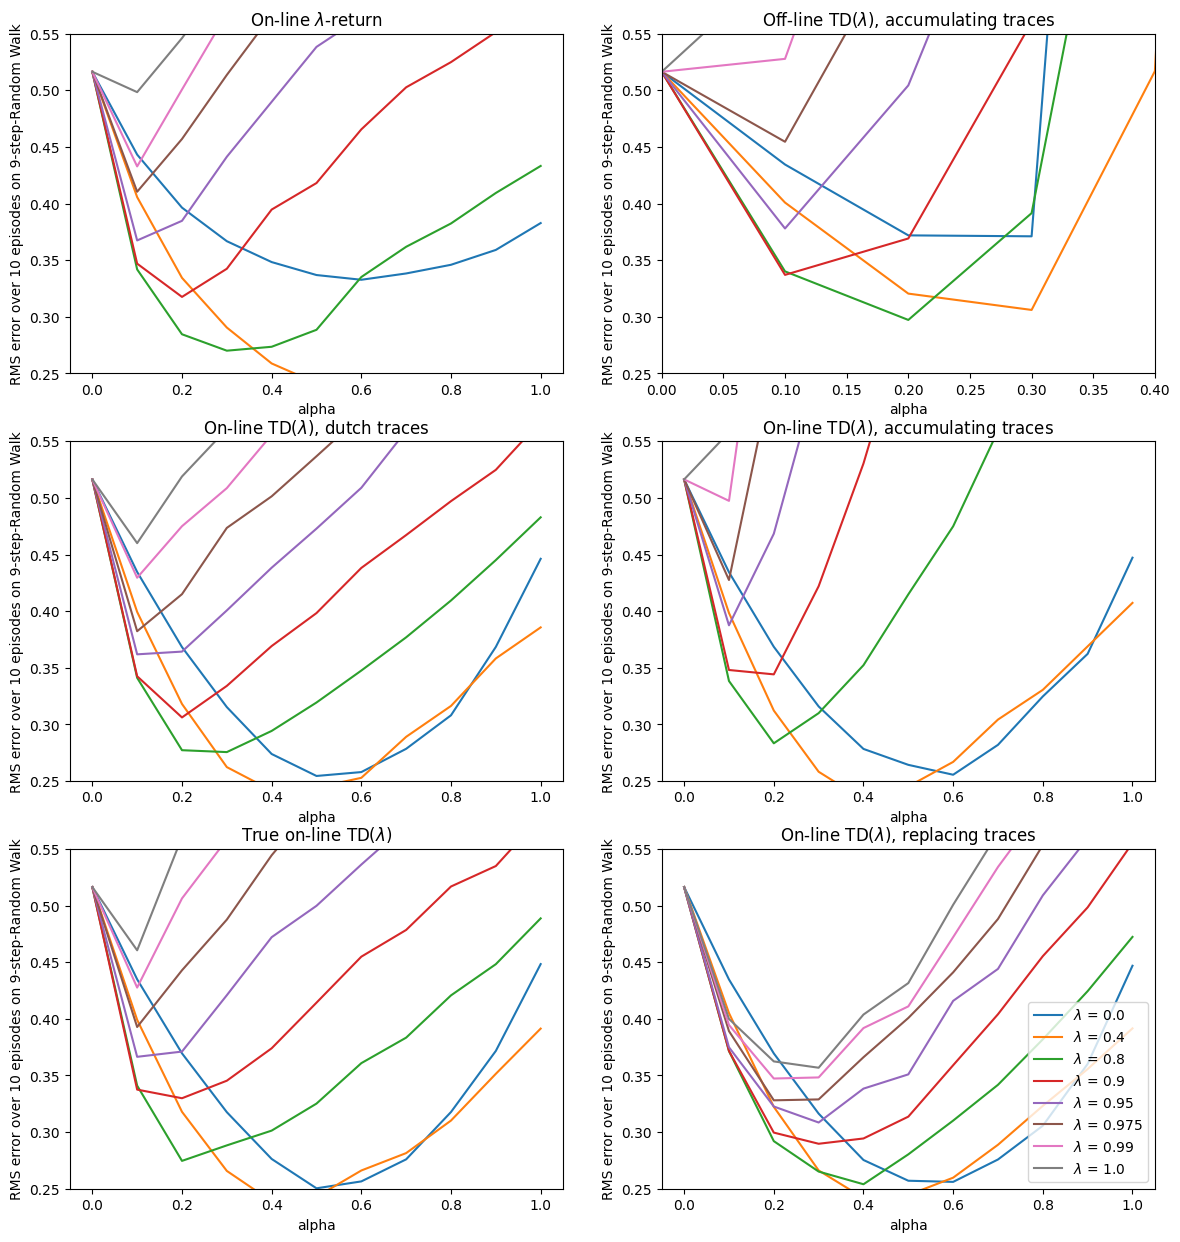

In [26]:
fig, ax = plt.subplots(3,2, figsize= (14,15))

for i in range(0, len(LAMBDAS)):
    ax[0][0].plot(ALPHAS, rms_errors_lamdaReturn_online_9[i, :], label=f"$\lambda$ = {LAMBDAS[i]}")
    ax[0][1].plot(ALPHAS, rms_errors_TDLambda_Offline_Accumulating_9[i, :], label=f"$\lambda$ = {LAMBDAS[i]}")

    ax[1][0].plot(ALPHAS, rms_errors_TDLambda_Online_Dutch_9[i, :], label=f"$\lambda$ = {LAMBDAS[i]}")
    ax[1][1].plot(ALPHAS, rms_errors_TDLambda_Online_Accumulating_9[i, :], label=f"$\lambda$ = {LAMBDAS[i]}")

    ax[2][0].plot(ALPHAS, rms_errors_TDLambda_True_Online_9[i, :], label=f"$\lambda$ = {LAMBDAS[i]}")
    ax[2][1].plot(ALPHAS, rms_errors_TDLambda_Online_Replacing_9[i, :], label=f"$\lambda$ = {LAMBDAS[i]}")

ax[0][0].set_title(f"On-line $\lambda$-return")
ax[0][1].set_title(f"Off-line TD($\lambda$), accumulating traces")

ax[1][0].set_title(f"On-line TD($\lambda$), dutch traces")
ax[1][1].set_title(f"On-line TD($\lambda$), accumulating traces")

ax[2][0].set_title(f"True on-line TD($\lambda$)")
ax[2][1].set_title(f"On-line TD($\lambda$), replacing traces")

for i in range(3):
    for j in range(2):
        ax[i][j].set_xlabel("alpha")
        ax[i][j].set_ylabel("RMS error over 10 episodes on 9-step-Random Walk")
        ax[i][j].set_ylim([0.25,0.55])

ax[0][1].set_xlim([0,0.4])

plt.legend()
plt.savefig("Lambda_based_methods.png")

Observation:
Compared to the performance of the methods on the 19-step Random Walk ...
- the instability of the off-line methods against $\alpha$ shifts to the right (about 0.4)
- TD(0) performs much better (can be reasoned due to lower distance to the terminal states)

## 7.5 Use eligibility traces to solve control problem

In this section, it will be shown how eligibility traces can be combined with the control algorithms Sarsa and Q-learning.

### 7.5.1 Grid world environment

The gridworld environment is a simple environment where an agent is placed on the top left corner of a grid with size width*height and the goal is to reach
the goal which is placed at bottom right corner. The agent can walk left, right up and down and it gets zero reward until it reaches the goal (+1).

Create environment

In [27]:
import numpy as np
import pickle
from tqdm import tqdm

class GridWorld():
    """
    Grid world environment 

    observation space:
    # flattened position on grid 
    -------------------------------------------------------------
    Attributes:

    action_space:
        Action space of environment

    observation_space:
        Observation space of environment   

    -------------------------------------------------------------

    Methods:

    reset:
        Reset game so that agent starts at top left corner

    step:
        Perform an action on the environment

    render:
        Render the environment by printing the result on terminal
    """
    def __init__(self, width, height):

        self.action_space = [0,1,2,3]
        self.num_states = width * height
        self.width = width
        self.height = height
        # reset the environment
        self.reset()

    def reset(self):
        """
        Reset game so that agent starts at top left corner
        """
        self.current_state = 0
        self.current_round = 0
        self.action_taken = None

        return self.current_state
    
    def step(self, action):
        """   
        Perform an action on the environment

        parameters:

        Action space:
            # 0: Go left
            # 1: Go right
            # 2: Go up
            # 3: Go down
            
        """
        reward = 0

        # convert to 2d position
        row = self.current_state // self.width
        col = self.current_state % self.width

        if action == 0:  
            if col > 0:
                col -= 1

        elif action == 1:  
            if col < self.width - 1:
                col += 1

        elif action == 2:  
            if row > 0:
                row -= 1

        elif action == 3:  
            if row < self.height - 1:
                row += 1
        else:
            raise ValueError("Invalid action.")

        # convert back to flattened position
        self.current_state = row * self.width + col
        
        if self.current_state == self.num_states - 1: # goal reached
            reward = 1

        self.action_taken = action

        self.current_round += 1

        done = self.current_state == self.num_states - 1 or self.current_round > self.num_states * 100

        return self.current_state, reward, done
    

    def render(self):
        state_to_string = {
            0: "left",
            1: "right",
            2: "up",
            3: "down"
        }
        print(f"Current Round: {self.current_round}, Action taken: {state_to_string[self.action_taken]}")
        row = ""
        for y in range(self.height):
            for x in range(self.width):
                index = y * self.width + x
                if index == self.current_state:
                    row += "P "  
                else:
                    row += ". "  
            row += "\n"

        print(row)

Test environment

In [28]:
def play_random_episode_GridWorld(width, height):
    env = GridWorld(width=width, height=height)
    done = False
    while not done:
        action = np.random.choice(env.action_space)
        new_state, reward, d = env.step(action)
        env.render()
        done = d

play_random_episode_GridWorld(10,8)

Current Round: 1, Action taken: right
. P . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 

Current Round: 2, Action taken: left
P . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 

Current Round: 3, Action taken: left
P . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 

Current Round: 4, Action taken: left
P . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 

Current Round: 5, Action taken: down
. . . . . . . . . . 
P . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . 

### 7.5.2 Sarsa($\lambda$)

The eligibility trace for a given state-action pair is defined as $E(s,a) \in R^+$ and the updating formula for the dutch trace of state $S_t$ where action $A_t$ was performed at time step $t$ is defined as $$E_t(S_t,A_t) = (1-\alpha)\gamma \lambda E_{t-1}(S_t,A_t) +1 \ .$$
 For all other state action pairs $s\neq S_t$, $a\neq 
A_t$ it holds
$$E_t(s,a) = \gamma \lambda E_{t-1}(s,a) \ .$$
Again, for the special cases $\alpha=0$ and $\alpha=1$ we are speaking of accumulating traces resp. replacing traces.

The update formula for Sarsa($\lambda$) is given as follows:
\begin{equation}
    Q_{t+1} = Q_t(s,a) + \alpha \delta_t E_t(s,a) \ 
\end{equation}
where $\delta_t = R_{t+1} + \gamma Q_t(S_{t+1}, A_{t+1}) - Q_t(S_t, A_t)$. 

Sarsa($\lambda$) - Implementation

In [29]:
def SarsaTDLambda(env, l, alpha, gamma, initial_Q, epsilon, num_episodes,  mode = "dutch"):
    """
    Sarsa(lambda) method 

    Parameters:
    env:
        Environment under which method is trained
    l: 
        decay rate
    gamma:
        discount factor
    initial_Q:
        initial state-action values
    epsilon:
        exploration rate
    alpha:  
        learning rate: impact of prediction error
    """
    Q = initial_Q

    def epsilon_greedy_policy(state):
        # exploration
        if np.random.random() < epsilon:
            action = np.random.randint(len(env.action_space))

        # exploitation
        else:
            max_ids = np.where(Q[state, :] == max(Q[state, :]))[0]
            action = np.random.choice(max_ids) 
        return action
    
    rounds_needed = np.zeros(num_episodes)
    total_rewards = np.zeros(num_episodes)

    for e in tqdm(range(num_episodes)):
        E = np.zeros_like(Q)

        state = env.reset()
        action = epsilon_greedy_policy(state)
        total_reward = 0

        while True:
            next_state, reward, done = env.step(action) # perform action
            next_action = epsilon_greedy_policy(state)

            delta = reward + gamma * Q[next_state, next_action] - Q[state, action]
            total_reward += reward

            # update eligibility traces according to mode
            if mode == "dutch":
                E[state, action] = (1-alpha) * E[state, action] + 1
            elif mode == "accumulate":
                E[state, action] = E[state, action] + 1
            elif mode == "replacing_traces":
                E[state, action] = 1
            else:
                print("Wrong mode. Dutch trace will be used")
                E[state, action] = (1-alpha) * E[state, action] + 1

            Q = Q + alpha * delta * E
            E = gamma * l  * E

            state = next_state
            action = next_action

            if done: 
                rounds_needed[e] = env.current_round
                total_rewards[e] = total_reward
                break

    return Q, rounds_needed, total_rewards

Setting for evaluation of control methods

In [30]:
ENV_GRIDWORLD = GridWorld(width=10, height=8)
Q_INITIAL_GRIDWORLD = np.zeros((ENV_GRIDWORLD.num_states, len(ENV_GRIDWORLD.action_space) ))
EPSILON_GRIDWORLD = 0.1
LEARNING_RATE_GRIDWORLD = 0.8
GAMMA_GRIDWORLD = 0.9
LAMBDA_GRIDWORLD = 0.9
NUM_EPISODES = 1000

Train Sarsa agent

In [31]:
Q_Sarsa , rounds_needed_Sarsa, total_rewards_Sarsa = SarsaTDLambda(env=ENV_GRIDWORLD,
                  l=LAMBDA_GRIDWORLD,
                  alpha=LEARNING_RATE_GRIDWORLD,
                  gamma=GAMMA_GRIDWORLD,
                  initial_Q= Q_INITIAL_GRIDWORLD,
                  epsilon=EPSILON_GRIDWORLD,
                  num_episodes=NUM_EPISODES)

100%|██████████| 1000/1000 [00:01<00:00, 802.36it/s]


Test trained Sarsa agent

In [32]:
def play_greedy_GridWorld(Q, env):
    def greedy_policy(Q, state):
        max_ids = np.where(Q[state, :] == max(Q[state, :]))[0]
        action = np.random.choice(max_ids) 
        return action
    
    state = env.reset()
    done = False
    while not done:
        action = greedy_policy(Q, state)
        new_state, reward, d = env.step(action)
        env.render()
        done = d

        state = new_state

play_greedy_GridWorld(Q_Sarsa, ENV_GRIDWORLD)

Current Round: 1, Action taken: right
. P . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 

Current Round: 2, Action taken: right
. . P . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 

Current Round: 3, Action taken: right
. . . P . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 

Current Round: 4, Action taken: down
. . . . . . . . . . 
. . . P . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 

Current Round: 5, Action taken: down
. . . . . . . . . . 
. . . . . . . . . . 
. . . P . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . 

Evaluate performance of Sarsa($\lambda$) for different values of $\lambda$

In [33]:
LAMBDA_GRIDWORLD = np.linspace(0.0,1.0,10)


rounds_needed_Sarsa = np.zeros((10, NUM_EPISODES))
total_rewards_Sarsa = np.zeros((10, NUM_EPISODES))

for i, l in enumerate(LAMBDA_GRIDWORLD):
    Q_Sarsa , rounds_needed_Sarsa[i], total_rewards_Sarsa[i]  = SarsaTDLambda(env=ENV_GRIDWORLD,
                    l=l,
                    alpha=LEARNING_RATE_GRIDWORLD,
                    gamma=GAMMA_GRIDWORLD,
                    initial_Q= Q_INITIAL_GRIDWORLD,
                    epsilon=EPSILON_GRIDWORLD,
                    num_episodes=NUM_EPISODES)

 34%|███▍      | 340/1000 [00:00<00:00, 787.24it/s]


KeyboardInterrupt: 

Plot performance of Sarsa($\lambda$) 

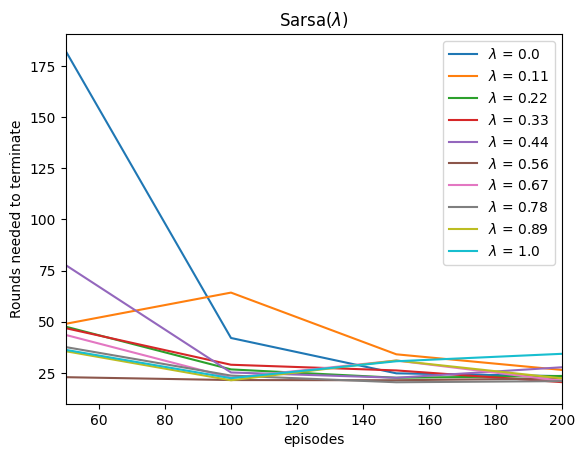

In [ ]:
import matplotlib.pyplot as plt

"""
Helper function to average success rate by window size
"""
def getSuccessRateWindowed(window_size, rewards):
    num_windows = int(np.ceil(len(rewards) / window_size))
    success_counts = [
            sum(rewards[i * window_size:(i + 1) * window_size]) /window_size for i in range(num_windows)
        ]
    windows = np.arange(window_size, len(rewards)+window_size, window_size)
    return windows, success_counts

for i in range(rounds_needed_Sarsa.shape[0]):
    windows_Sarsa, success_rate_Sarsa = getSuccessRateWindowed(50, rounds_needed_Sarsa[i])
    plt.plot(windows_Sarsa, success_rate_Sarsa, label = f"$\lambda$ = {np.round(LAMBDA_GRIDWORLD[i], 2)}")

plt.xlabel("episodes")
plt.ylabel("Rounds needed to terminate")
plt.title(f"Sarsa($\lambda$)")
plt.xlim([50,200])
    
plt.legend()
plt.show()

## 7.6 Watkins’s Q($\lambda$)

The update formula of the eligibility traces for Q($\lambda$) is given as follows:

\begin{equation}
    E_t(s,a)= 
\begin{cases}
    (1-\alpha) \gamma \lambda E_{t-1}(s,a) + I_{sS_t}I_{aA_t},& \text{if } Q_{t-1}(S_t,A_t)= \max_{a} Q_{t-1}(S_t,a) \ \text{and mode="dutch"} \\
    (1-I_{sS_t}I_{aA_t}) \gamma \lambda E_{t-1}(s,a) + I_{sS_t}I_{aA_t},& \text{if } Q_{t-1}(S_t,A_t)= \max_{a} Q_{t-1}(S_t,a) \ \text{and mode="replacing"} \\
    \gamma \lambda E_{t-1}(s,a) + I_{sS_t}I_{aA_t},& \text{if } Q_{t-1}(S_t,A_t)= \max_{a} Q_{t-1}(S_t,a) \ \text{and mode="accumulating"} \\
    I_{sS_t}I_{aA_t},              & \text{otherwise}
\end{cases}
\end{equation}

$I$ is an indicator function to distinguish between visited and non-visited states.

The update formula for the value estimates for Q($\lambda$) is given as follows:
\begin{equation}
    Q_{t+1} = Q_t(s,a) + \alpha \delta_t E_t(s,a) \ 
\end{equation}
where $$\delta_t = R_{t+1} + \gamma \max_{a'} Q_t(S_{t+1}, a') - Q_t(S_t, A_t)$$

Q($\lambda$) - Implementation

In [85]:
def WatkinsQTDLambda(env, l, alpha, gamma, initial_Q, epsilon, num_episodes,  mode = "dutch"):
    """
    Q(lambda) algorithm.

    Parameters:
    env:
        Environment under which method is trained
    l: 
        decay rate
    gamma:
        discount factor
    initial_Q:
        initial state-action values
    epsilon:
        exploration rate
    alpha:  
        learning rate: impact of prediction error
    """
    Q = initial_Q

    def epsilon_greedy_policy(state):
        # exploration
        if np.random.random() < epsilon:
            action = np.random.randint(len(env.action_space))

        # exploitation
        else:
            max_ids = np.where(Q[state, :] == max(Q[state, :]))[0]
            action = np.random.choice(max_ids) 
        return action
    
    rounds_needed = np.zeros(num_episodes)
    total_rewards = np.zeros(num_episodes)

    for e in tqdm(range(num_episodes)):
        E = np.zeros_like(Q)

        state = env.reset()
        action = epsilon_greedy_policy(state)
        total_reward = 0
        while True:
            next_state, reward, done = env.step(action) # perform action
            total_reward += reward
            next_action = epsilon_greedy_policy(state)

            max_ids = np.where(Q[state, :] == max(Q[state, :]))[0]
            
            max_action = None
            if next_action not in max_ids:
                max_action = np.random.choice(max_ids) 
            else:
                max_action = next_action

            delta = reward + gamma * Q[next_state, max_action] - Q[state, action]

            # update eligibility traces according to mode
            if mode == "dutch":
                E[state, action] = (1-alpha) * E[state, action] + 1
            elif mode == "accumulate":
                E[state, action] = E[state, action] + 1
            elif mode == "replacing_traces":
                E[state, action] = 1
            else:
                print("Wrong mode. Dutch trace will be used")
                E[state, action] = (1-alpha) * E[state, action] + 1

            Q = Q + alpha * delta * E
            if next_action == max_action: # check if action performed was greedy or not 
                E = gamma * l  * E
            else:
                E = np.zeros_like(Q) # reset eligibility traces since exploration was performed

            state = next_state
            action = next_action

            if done: 
                rounds_needed[e] = env.current_round
                total_rewards[e] = total_reward
                break


    return Q, rounds_needed, total_rewards

Train Q-learning agent

In [86]:
LAMBDA_GRIDWORLD = 0.5

Q_Watkins , rounds_needed_Watkins, total_rewards_Watkins = WatkinsQTDLambda(env=ENV_GRIDWORLD,
                  l=LAMBDA_GRIDWORLD,
                  alpha=LEARNING_RATE_GRIDWORLD,
                  gamma=GAMMA_GRIDWORLD,
                  initial_Q= Q_INITIAL_GRIDWORLD,
                  epsilon=EPSILON_GRIDWORLD,
                  num_episodes=NUM_EPISODES)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 451.17it/s]


Test trained Q-learning agent

In [87]:
play_greedy_GridWorld(Q_Watkins, ENV_GRIDWORLD)

Current Round: 1, Action taken: down
. . . . . . . . . . 
P . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 

Current Round: 2, Action taken: down
. . . . . . . . . . 
. . . . . . . . . . 
P . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 

Current Round: 3, Action taken: down
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
P . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 

Current Round: 4, Action taken: right
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. P . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 

Current Round: 5, Action taken: down
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. . . . . . . . . . 
. P . . . . . . . . 
. . . . . . . . . . 
. . . . . . 

Evaluate Q($\lambda$) for different values of $\lambda$

In [88]:
LAMBDA_GRIDWORLD = np.linspace(0.0,1.0,10)

rounds_needed_Watkins = np.zeros((10, NUM_EPISODES))
total_rewards_Watkins = np.zeros((10, NUM_EPISODES))

for i, l in enumerate(LAMBDA_GRIDWORLD):
    Q_Watkins , rounds_needed_Watkins[i], total_rewards_Watkins[i]  = WatkinsQTDLambda(env=ENV_GRIDWORLD,
                    l=l,
                    alpha=LEARNING_RATE_GRIDWORLD,
                    gamma=GAMMA_GRIDWORLD,
                    initial_Q= Q_INITIAL_GRIDWORLD,
                    epsilon=EPSILON_GRIDWORLD,
                    num_episodes=NUM_EPISODES)

100%|██████████| 1000/1000 [00:01<00:00, 701.17it/s]


Plot performance of Q($\lambda$) 

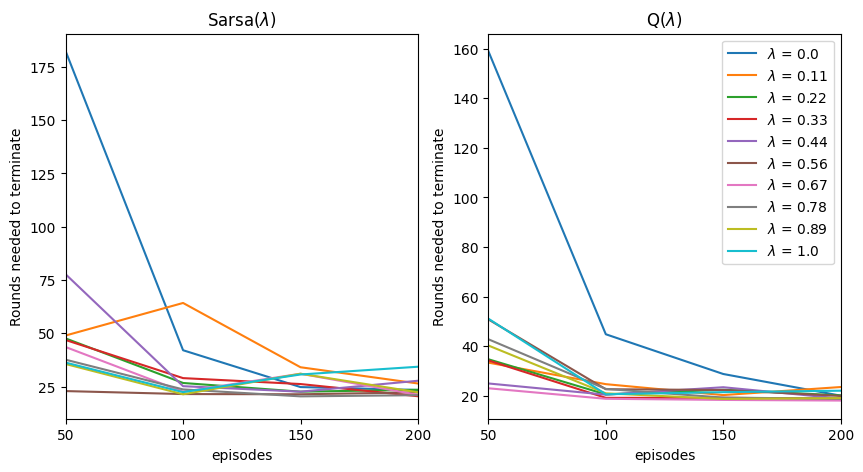

In [89]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

for i in range(rounds_needed_Sarsa.shape[0]):
    windows_Sarsa, success_rate_Sarsa = getSuccessRateWindowed(50, rounds_needed_Sarsa[i])
    ax[0].plot(windows_Sarsa, success_rate_Sarsa, label = f"$\lambda$  = {np.round(LAMBDA_GRIDWORLD[i], 2)}")

for i in range(rounds_needed_Watkins.shape[0]):
    windows_Watkins, success_rate_Watkins = getSuccessRateWindowed(50, rounds_needed_Watkins[i])
    ax[1].plot(windows_Watkins, success_rate_Watkins, label = f"$\lambda$ = {np.round(LAMBDA_GRIDWORLD[i], 2)}")

for i in range(2):
    ax[i].set_xlim([50,200])
    ax[i].set_xticks(windows_Watkins[:4])
    ax[i].set_xlabel("episodes")
    ax[i].set_ylabel("Rounds needed to terminate")

 
ax[0].set_title(f"Sarsa($\lambda$)")
ax[1].set_title(f"Q($\lambda$)")

plt.legend()
plt.savefig("Gridworld.png")
plt.show()

Observation
- both methods, Sarsa($\lambda$) and Q($\lambda$), need fewer episodes to yield good performance for intermediate values of $\lambda$ in comparison to the extremes $\lambda=0$ and $\lambda=1$
- the performance of Q(\$lambda$) seems slightly more stable but this could be random because only one run was performed

### 7.6 Test eligibility traces on a more complex environment - Car Parking

### 7.6.1 Description of the environment

The car parking task is inspired by Cichosz (1995) and describes as follows:
- a rectangle car is surrounded by a wall and its goal is to reach the garage 
- Action space: 
    - 1. Drive straight 
    - 2. Turn left 
    - 3. Turn right

    Note that the velocity of the car is defined to be constant.
- Observation space: The car is assigned to discrete regions defined by the x-position (9 regions), y-position (10) and the turn angle $\sigma$ (14 regions)
The regions are dense in the near of the garange and sparse at the initial position of the car. In total, the environment has 9*19*14=1260 states.
- Reward shaping: When the car reaches the goal it receives +1 reward. For all other cases, it receives 0 reward.
- Termination: The episode ends if the car reaches the goal or if it hits the wall or of too many actions were performed.


In [90]:
import numpy as np
import pickle
import math
import bisect
import pygame
from tqdm import tqdm 


# Regions defined by x-position, y-position and turn angle sigma
LOOKUPX = [-0.5, 
           0.0, 
           0.5, 
           1.0, 
           2.0, 
           3.0, 
           4.0, 
           6.0]

LOOKUPY = [0.5, 
           1.0, 
           2.0, 
           3.0, 
           4.0, 
           5.0 , 
           6.0, 
           8.0, 
           10.0]

LOOKUPSIGMA = [19.0/20.0*math.pi,
               20.0/20.0*math.pi,
               21.0/20.0*math.pi,
               22.0/20.0*math.pi,
               23.0/20.0*math.pi,
               24.0/20.0*math.pi,
               25.0/20.0*math.pi,
               26.0/20.0*math.pi,
               27.0/20.0*math.pi,
               28.0/20.0*math.pi,
               29.0/20.0*math.pi,
                3.0/2.0*math.pi,
                31.0/20.0*math.pi]

# Initial positionn of the car
INITIAL_Position_x = 6.15
INITIAL_Position_y = 10.47
INITIAL_sigma = 3.7

# Car configuration
CAR_HEIGHT = 2.0
CAR_WIDTH = 4.0

# environment configuration
GARAGE_LEFT_X = 1.5
GARAGE_RIGHT_X = -1.5
GARAGE_BOTTOM_Y = 3.0
GARAGE_TOP_Y = -3
WALL_LEFT_END_X = 8.5
WALL_BOTTOM_END_Y = 13.0

# Scale environment for visualization
SCALE = 20

"""
normalize angle in radians
"""
def normalize_rad(rad):
    return rad % (2 * math.pi)

"""
find region of car corresponding to x-position, y-position or turn angle sigma
"""
def get_index(arr, i):
    idx = bisect.bisect_left(arr, i)  # Find first index where arr[idx] >= i

    return idx

"""
convert car position and turn angle to state
"""
def get_state_index(pos_x, pos_y, s):
    index_x = get_index(LOOKUPX, pos_x)
    index_y = get_index(LOOKUPY, pos_y)
    index_sigma = get_index(LOOKUPSIGMA, normalize_rad(s))

    return index_x * 10 * 14 + index_y * 14 + index_sigma # states are saved in flattened version

class CarParking():
    def __init__(self, render_mode=None):
        # 0: Drive straight
        # 1: Turn Left
        # 2: Turn right
        self.action_space = [0,1,2]

        self.num_states = 9*10*14

        # reset the environment
        self.reset()

        # render mode is used to train without visualization and render trained agent on GUI
        self.render_mode = render_mode


        # configuration of GUI 
        self.width, self.height = 800, 600

        # corners of wall
        self.wall_points = [(self.width/2 - WALL_LEFT_END_X* SCALE, self.height/2 + WALL_BOTTOM_END_Y*SCALE),
                    (self.width/2 - WALL_LEFT_END_X* SCALE, self.height/2 + GARAGE_BOTTOM_Y*SCALE),
                    (self.width/2 - GARAGE_LEFT_X* SCALE, self.height/2 + GARAGE_BOTTOM_Y*SCALE),
                    (self.width/2 - GARAGE_LEFT_X* SCALE, self.height/2 + GARAGE_TOP_Y*SCALE),
                    (self.width/2 - GARAGE_RIGHT_X* SCALE, self.height/2 + GARAGE_TOP_Y*SCALE),
                    (self.width/2 - GARAGE_RIGHT_X* SCALE, self.height/2 + WALL_BOTTOM_END_Y*SCALE)]

        # use the wall points to draw polygon
        poly_surf = pygame.Surface((self.width, self.height), pygame.SRCALPHA)
        poly_surf.fill((0, 0, 0, 0))
        pygame.draw.polygon(poly_surf, (255, 255, 255), self.wall_points, 2)
        self.polygon_mask = pygame.mask.from_surface(poly_surf) # embed polygon with a mask for collision detection

        # car visualization
        self.box_color = (255, 0, 0)  # Red color
        self.box_surface = pygame.Surface((CAR_WIDTH*SCALE, CAR_HEIGHT*SCALE), pygame.SRCALPHA)
        rect = self.box_surface.get_rect()
        pygame.draw.rect(self.box_surface, self.box_color, rect, 2)
        
        self.screen = None # is used for rendering

        # save positions for plotting purpose (Note: Uncomment these lines if agent is trained on a huge number of episodes)
        self.positions_x = np.array([])
        self.positions_y = np.array([])

    def reset(self):
        """
        Reset game so that agent starts at initial position 
        """
        index_x = get_index(LOOKUPX, INITIAL_Position_x)
        index_y = get_index(LOOKUPY, INITIAL_Position_y)
        index_sigma = get_index(LOOKUPSIGMA, INITIAL_sigma)

        self.new_state = index_x * 10 * 14 + index_y * 14 + index_sigma
        
        self.last_state = self.new_state
        self.action_taken = None
        
        self.current_round = 0

        self.pos_x = INITIAL_Position_x
        self.pos_y = INITIAL_Position_y
        self.sigma = INITIAL_sigma

        return self.last_state
    
    def step(self, action):
        """   
        Perform an action on the environment

        parameters:

        action:
            # 0: Drive straight
            # 1: Turn Left
            # 2: Turn right
        """

        self.last_state = self.new_state
        reward = 0

        if action == 0: # Drive straight
            sigma_old = self.sigma
            self.sigma = self.sigma + 0.5 * 1.0/5.0
            self.pos_x = self.pos_x - 0.5 * math.sin(sigma_old) + 0.5 * math.sin(self.sigma)
            self.pos_y = self.pos_y + 0.5 * math.sin(sigma_old) - 0.5 * math.sin(self.sigma)
            
            self.new_state = get_state_index(self.pos_x, self.pos_y, self.sigma)

        elif action == 1: # Turn left 
            sigma_old = self.sigma
            self.sigma = self.sigma + 0.5 * 1.0/-5.0
            self.pos_x = self.pos_x - 0.5 * math.sin(sigma_old) + 0.5 * math.sin(self.sigma)
            self.pos_y = self.pos_y + 0.5 * math.sin(sigma_old) - 0.5 * math.sin(self.sigma)

            self.new_state = get_state_index(self.pos_x, self.pos_y, self.sigma)

        elif action == 2: # Drive straight
            self.pos_x = self.pos_x + 0.5 * 1 * math.cos(self.sigma)
            self.pos_y = self.pos_y + 0.5 * 1 * math.sin(self.sigma)

            self.new_state = get_state_index(self.pos_x, self.pos_y, self.sigma)
        else:
            return ValueError
    
        if self.pos_y <= 0: # car raches the garage. Note. The center of the garage is located at x=0 and y=0.
            reward = 1

        self.action_taken = action 

        self.current_round += 1

        # rotate car using turn angle 
        self.rotated_box = pygame.transform.rotozoom(self.box_surface, math.degrees(self.sigma),1)

        # position the car and embed it with a mask for collision detection
        self.car = self.rotated_box.get_rect(center=(self.width/2 - self.pos_x  *SCALE,  self.height/2 + self.pos_y *SCALE))
        car_mask = pygame.mask.from_surface(self.rotated_box)

        collision = False
        if car_mask.overlap(self.polygon_mask, (-self.car.left,-self.car.top)): # check for collision
            collision = True

        # save positions for plotting purpose (Note: Uncomment these lines if agent is trained on a huge number of episodes)
        self.positions_x = np.append(self.positions_x, self.car.centerx)
        self.positions_y = np.append(self.positions_y, self.car.centery)

        # episode ends if collision was detected or goal was reached or too many steps were performed
        done = collision == True or self.pos_y <= 0 or self.current_round >= 1000

        return self.new_state, reward, done
    
    def render(self):    
        if self.render_mode == "human":
            if self.screen is None: # for evaluating
                pygame.init()
                self.screen = pygame.display.set_mode((self.width, self.height))
                pygame.display.set_caption("Car Parking")
        elif self.render_mode == "rgb_array": # for training
            if self.screen is None:
                pygame.init()
                self.screen = pygame.Surface((self.width, self.height))

        # clean screen
        self.screen.fill((0,0,0))

        # draw wall
        box_color = (255, 255, 255)  
        pygame.draw.polygon(self.screen, box_color, self.wall_points, 2)

        # draw car
        self.screen.blit(self.rotated_box, self.car)

        # update GUI 
        if self.render_mode =="human":
            pygame.display.flip()

        if self.render_mode == "rgb_array":
            return np.array(pygame.surfarray.array3d(self.screen)).transpose(1, 0, 2)

    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None

### 7.6.2 Train Sarsa($\lambda) agent on environment

In [91]:
ENV_CARPARKING = CarParking()
Q_INITIAL_CARPARKING = np.zeros((ENV_CARPARKING.num_states, len(ENV_CARPARKING.action_space) ))
EPSILON_CARPARKING = 0.2
GAMMA_CARPARKING = 0.9
NUM_EPISODES = 10000

Q , _, total_rewards = SarsaTDLambda(env=ENV_CARPARKING,
                  l=0.4,
                  alpha=0.2,
                  gamma=GAMMA_CARPARKING,
                  initial_Q= Q_INITIAL_CARPARKING,
                  epsilon=EPSILON_CARPARKING,
                  num_episodes=NUM_EPISODES)

 81%|████████▏ | 8129/10000 [03:03<00:42, 44.18it/s] 


KeyboardInterrupt: 

# 7.6.3 Visualize paths taken by the car

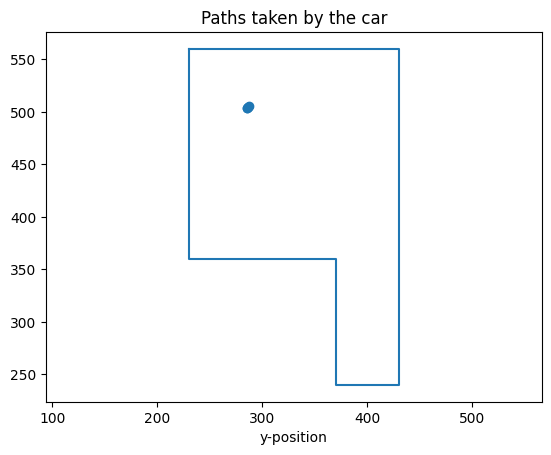

In [ ]:
import matplotlib.pyplot as plt

boundary_positions_x = np.array([])
boundary_positions_y = np.array([])
first_x = None
first_y = None
for i, point in enumerate(ENV_CARPARKING.wall_points):
    x, y = point
    if i ==0:
        first_x = x
        first_y = y
    
    boundary_positions_x = np.append(boundary_positions_x, x)
    boundary_positions_y = np.append(boundary_positions_y, y)

boundary_positions_x = np.append(boundary_positions_x, first_x)
boundary_positions_y = np.append(boundary_positions_y, first_y)

plt.plot(boundary_positions_x, boundary_positions_y)
plt.xlabel("x-position")
plt.xlabel("y-position")
plt.title("Paths taken by the car")

plt.axis("equal")
plt.scatter(ENV_CARPARKING.positions_x, ENV_CARPARKING.positions_y)

### 7.6.4 Render trained agent on GUI

In [45]:
import time
ENV_CARPARKING = CarParking(render_mode="human")
pygame.init()

def greedy_policy(Q, state):
    max_ids = np.where(Q[state, :] == max(Q[state, :]))[0]
    action = np.random.choice(max_ids) 
    return action

state = ENV_CARPARKING.reset()
done = False
quit = False

while not done:
    for event in pygame.event.get():
        if event.type == pygame.QUIT: # user quits the display
            quit = True
            break

    action = greedy_policy(Q, state)
    new_state, reward, terminated = ENV_CARPARKING.step(action)

    ENV_CARPARKING.render()
    done = terminated or quit

    state = new_state
    time.sleep(0.5)

ENV_CARPARKING.close()

### 7.6.5 Evaluate agent for different values of $\lambda$ and $\alpha$

In [46]:
Q_INITIAL_CARPARKING = np.zeros((ENV_CARPARKING.num_states, len(ENV_CARPARKING.action_space) ))
EPSILON_CARPARKING = 0.1
GAMMA_CARPARKING = 0.95
NUM_EPISODES = 10000

LAMBDA_CARPARKING =  [0.0, 0.4, 0.7, 1.0]
LEARNING_RATE_CARPARKING = [0.2, 0.6, 0.9]

total_rewards_grid = np.zeros((len(LEARNING_RATE_CARPARKING), len(LAMBDA_CARPARKING), NUM_EPISODES))

if os.path.exists('total_rewards_grid.array'):
        with open('total_rewards_grid.array', 'rb') as file:
                total_rewards_grid = pickle.load(file)

else:
        for i in range(len(LEARNING_RATE_CARPARKING)):
                for j in range(len(LAMBDA_CARPARKING)):
                        env = CarParking()
                        _ , rounds_needed, total_rewards = SarsaTDLambda(env=env,
                                l=LAMBDA_CARPARKING[j],
                                alpha=LEARNING_RATE_CARPARKING[i],
                                gamma=GAMMA_CARPARKING,
                                initial_Q= Q_INITIAL_CARPARKING,
                                epsilon=EPSILON_CARPARKING,
                                num_episodes=NUM_EPISODES)
                        
                        total_rewards_grid[i,j] = total_rewards

                with open('total_rewards_grid.array', 'wb') as file:
                        pickle.dump(total_rewards_grid, file)

Plot success rate

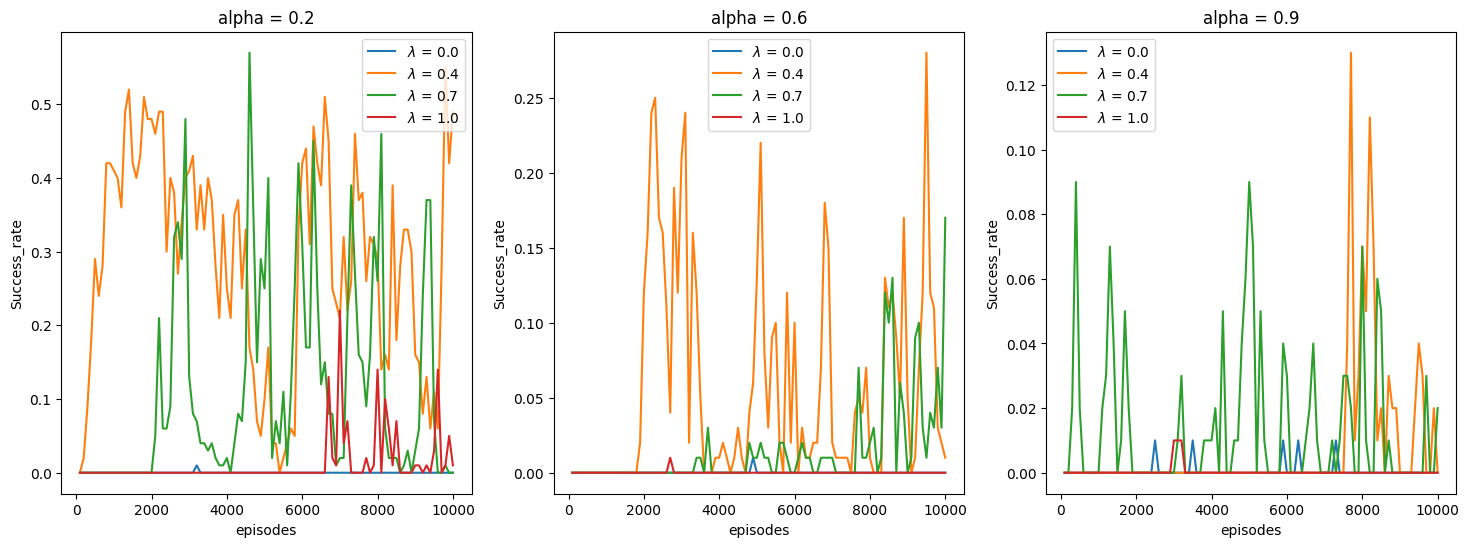

In [ ]:
len_learning_rate =  len((LEARNING_RATE_CARPARKING))
fig, ax = plt.subplots(1, 3, figsize= (18,6))
for i in range(len(LEARNING_RATE_CARPARKING)):
    for j in range(len(LAMBDA_CARPARKING)):
        windows, success_rate = getSuccessRateWindowed(100, total_rewards_grid[i,j])
        ax[i].plot(windows, success_rate, label = f"$\lambda$ = {LAMBDA_CARPARKING[j]}")
        ax[i].legend()
        ax[i].set_xlabel("episodes")
        ax[i].set_ylabel("Success_rate")
        ax[i].set_title(f"alpha = {LEARNING_RATE_CARPARKING[i]}")

plt.legend()
plt.savefig("Carparking_Evaluation.png")